# Introduction 

This notebook demonstrates the encoding and decoding operations that can be done. 
We will use the Fashion MNIST Dataset to train various models:

    - Simple shape of clothes reconstruction with autoencoders
    - Noise Supression using CNN Autoencoders
    - A deeoer CNN 
    - Using Data Augmentation

# Importing the necessary libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import random

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K


2024-10-01 19:29:51.968298: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-01 19:29:51.968955: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-01 19:29:51.971608: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-01 19:29:51.979914: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-01 19:29:51.994281: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

# Creating Helper Functions 

## Structural Similarity Index (SSIM)
>SSIM (Structural Similarity Index) is a metric used to evaluate the similarity between two images by considering changes in luminance, contrast, and structure. Unlike Mean Squared Error (MSE), which measures pixel-by-pixel differences, SSIM models how the human eye perceives image quality. It compares local patterns of pixel intensities that have been normalized for luminance and contrast.

**Key Advantages of SSIM over MSE:**
 - Perceptual Accuracy: SSIM aligns better with human visual perception, capturing image quality as a human would see it. MSE may miss  perceptual details by only focusing on absolute errors.
 - Local Structure Sensitivity: SSIM takes into account the structural information of images, which helps it evaluate the visual content more effectively.
 - Robust to Small Changes: MSE can be highly sensitive to small pixel value changes, while SSIM is more robust, especially when the changes don’t impact the perceived image quality.
 - Luminance and Contrast Awareness: SSIM incorporates these factors, making it more effective at assessing variations in brightness or contrast that don’t necessarily degrade the overall image quality.
 

In [6]:
def ssim_metric(y_true, y_pred):
    
    y_true = tf.reshape(y_true, (-1, tf.shape(y_true)[1], tf.shape(y_true)[2], 1))
    y_pred = tf.reshape(y_pred, (-1, tf.shape(y_pred)[1], tf.shape(y_pred)[2], 1))

    ssim_value = tf.image.ssim(y_true, y_pred, max_val=1.0)

    return K.mean(ssim_value)

# 1. Simple Clothing Reconstruction:

Implementing a basic autoencoder to reconstruct the shapes of clothing items from the Fashion MNIST dataset.

## Importing the Dataset

In [2]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


## Data Visualisation

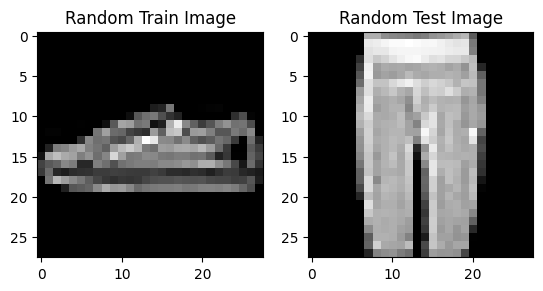

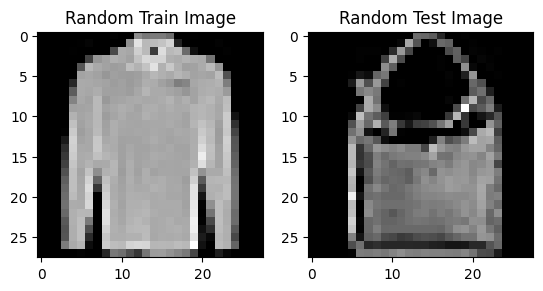

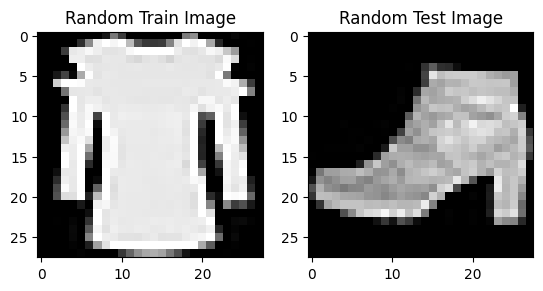

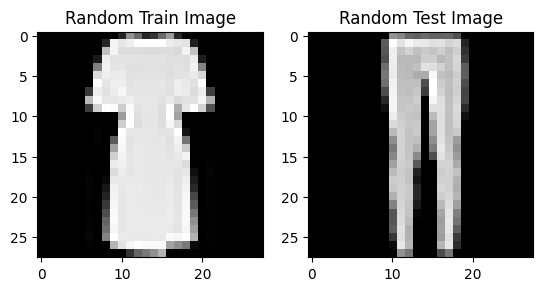

In [3]:
# Plotting random images from train and test

for i in range(4):
    i_train = random.randint(0, x_train.shape[0])
    i_test = random.randint(0, x_test.shape[0])

    f, axarr = plt.subplots(1, 2)
    axarr[0].imshow(x_train[i_train], cmap="grey")
    axarr[0].set_title('Random Train Image')
    axarr[1].imshow(x_test[i_test], cmap="grey")
    axarr[1].set_title('Random Test Image')

## Creating the Model 

In [4]:
class Autoencoder(Model):
  def __init__(self, latent_dim, shape):
    super().__init__()

    # Pass parameters
    self.latent_dim = latent_dim
    self.shape = shape

    # Create the Encoder layer
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])

    # Create the decoder layer
    self.decoder = tf.keras.Sequential([
        layers.Dense(int(tf.math.reduce_prod(shape)), activation='sigmoid'),
        layers.Reshape(shape)
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


So here we created the encoder and decoder layers with one hidden layer of "latent_dim" neurons

In [5]:
# Use the Autoencoder
shape = x_test.shape[1:]
latent_dim = 64

autoencoder = Autoencoder(latent_dim, shape)

I0000 00:00:1727803974.624364  299064 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-01 19:32:54.626005: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [7]:
# Compile the model

autoencoder.compile(
    optimizer='adam',
    loss=losses.MeanSquaredError(),
    metrics = [ssim_metric])

In [8]:
# Fit the model

history_decoder = autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))


Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0393 - ssim_metric: 0.4194 - val_loss: 0.0131 - val_ssim_metric: 0.6266
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0122 - ssim_metric: 0.6441 - val_loss: 0.0105 - val_ssim_metric: 0.6763
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0102 - ssim_metric: 0.6854 - val_loss: 0.0097 - val_ssim_metric: 0.6973
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0095 - ssim_metric: 0.7033 - val_loss: 0.0093 - val_ssim_metric: 0.7077
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0091 - ssim_metric: 0.7124 - val_loss: 0.0092 - val_ssim_metric: 0.7138
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0090 - ssim_metric: 0.7163 - val_loss: 0.0090 - val_ssim_metric: 0.7164
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0089 - ssim_metric: 0.7186 - val_loss: 0.0089 - val_ssim_metric: 0.7185
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms

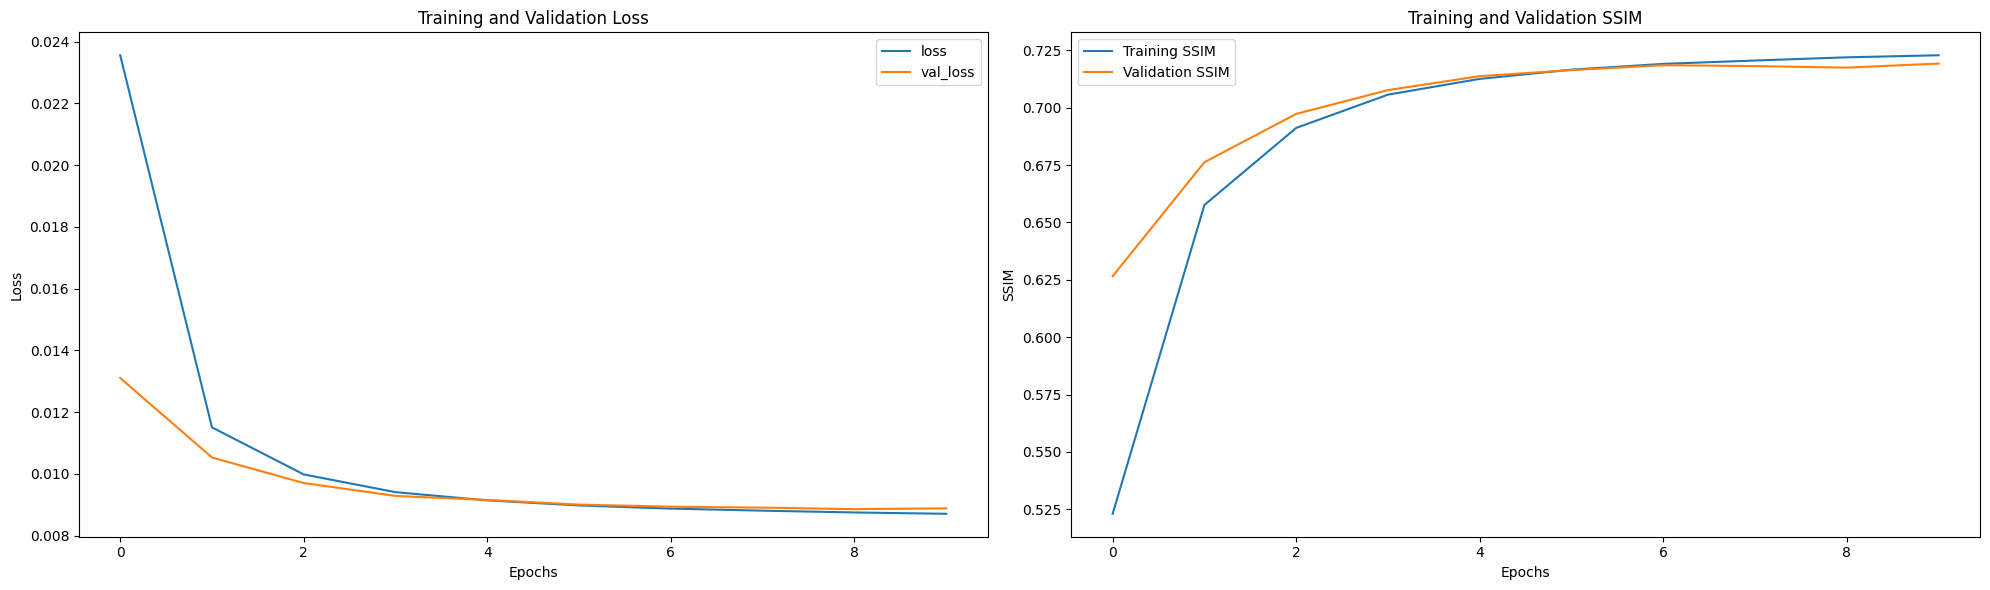

In [12]:
# Plot the history

# Convert history to a pandas DataFrame
history_decoder_df = pd.DataFrame(history_decoder.history)

# Create subplots
plt.figure(figsize=(20, 6)) 


plt.subplot(1, 2, 1)  
history_decoder_df[['loss', 'val_loss']].plot(ax=plt.gca())   
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')


plt.subplot(1, 2, 2)  
history_decoder_df['ssim_metric'].plot(ax=plt.gca(), label='Training SSIM')
history_decoder_df['val_ssim_metric'].plot(ax=plt.gca(), label='Validation SSIM')
plt.title('Training and Validation SSIM')
plt.xlabel('Epochs')
plt.ylabel('SSIM')
plt.legend()

 
plt.tight_layout()  
plt.show()


We can see that our model perfroms really well. However, some change could be made to imrove the SSIM metric.

### An overview of the Autoencoder architecture

In [13]:
# Visualizing the encoder and decoder layers

# Encoder
autoencoder.encoder.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (32, 784)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        50,240 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,240 (196.25 KB)

 Trainable params: 50,240 (196.25 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Decoder
autoencoder.decoder.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (32, 784)              │        50,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (32, 28, 28)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,960 (199.06 KB)

 Trainable params: 50,960 (199.06 KB)

 Non-trainable params: 0 (0.00 B)

### Testing the model on our dataset

In [16]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

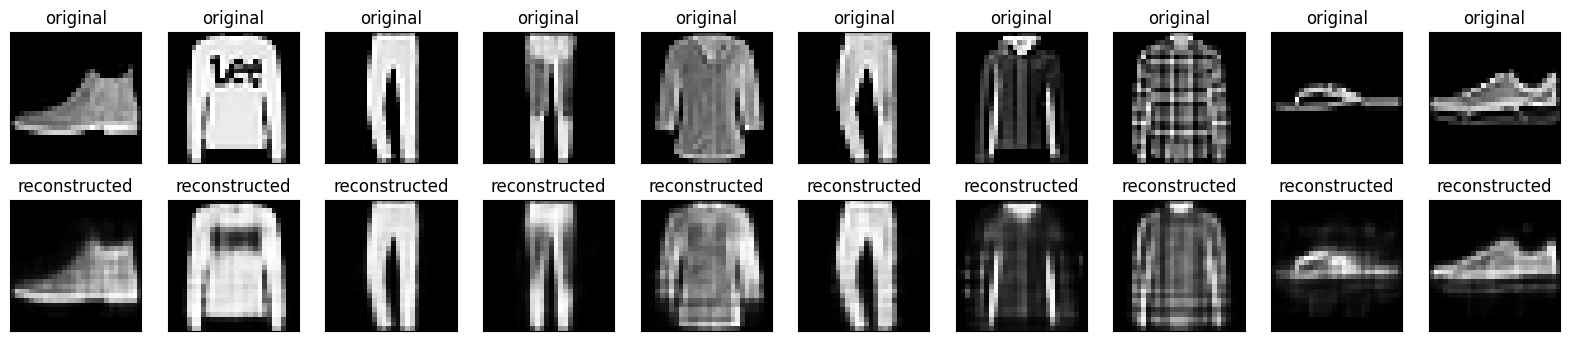

In [17]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

# 2. Noise Suppression with CNN Autoencoders:

Using a convolutional autoencoder to remove noise from images, showcasing how these models can improve image quality through denoising.

## Loading the data and preprocessing

In [18]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()


In [19]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [20]:
# Adding random noise to the images
noise_factor = 0.2

x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape)
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

print(x_train_noisy.shape)
print(x_test_noisy.shape)
print("Max value After Clipping")
print(tf.math.reduce_max(x_train_noisy).numpy())
print(tf.math.reduce_max(x_test_noisy).numpy())
print("Min value After Clipping")
print(tf.math.reduce_min(x_train_noisy).numpy())
print(tf.math.reduce_min(x_test_noisy).numpy())

(60000, 28, 28, 1)
(10000, 28, 28, 1)
Max value After Clipping
1.0
1.0
Min value After Clipping
0.0
0.0


## Data visualisation

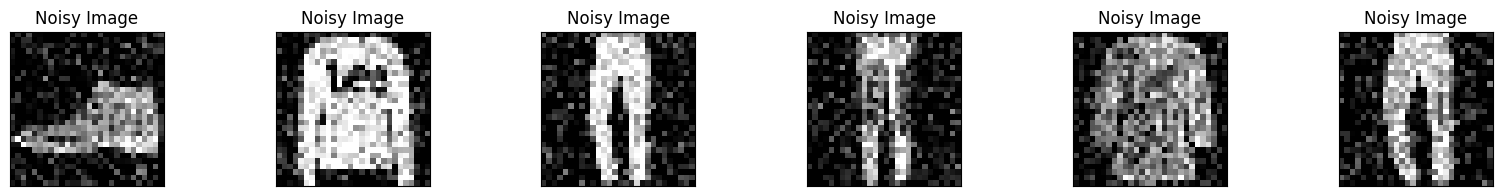

In [21]:
# Plotting the noisy images

n = 6
plt.figure(figsize=(20,2))

for i in range(n):
  ax = plt.subplot(1, n, i + 1)
  plt.imshow(x_test_noisy[i])
  plt.title("Noisy Image")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()


## Creating the Convolutional Autoencoder Model